In [39]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import read_data
from fare_net import FARE_Net

### Initializing Model

In [40]:
# Base Model
base_path = "log/original/60-1"
base_fare_net = FARE_Net(far_net_model_path=f"{base_path}/far_net_model.keras", e_net_model_path=f"{base_path}/e_net_model.keras")

# Enhanced Model
enhanced_path = "log/enhanced/60-1"
enhanced_fare_net = FARE_Net(far_net_model_path=f"{enhanced_path}/far_net_model.keras", e_net_model_path=f"{enhanced_path}/e_net_model.keras")

### Comparing Models

In [41]:
def visualize_error_data(data1=[],data2=[]):
  categories = list(range(1,16))
  values1 = data1
  values2 = data2

  # Number of categories
  n = 15

  # Set the width of the bars
  bar_width = 0.35

  # Set the positions of the bars on the x-axis
  r1 = np.arange(n)
  r2 = [x + bar_width for x in r1]

  # Create bar chart
  plt.bar(r1, values1, color='orange', width=bar_width, edgecolor='grey', label='Original')
  plt.bar(r2, values2, color='lightblue', width=bar_width, edgecolor='grey', label='Enhanced')

  # Add title and labels
  plt.title('Angular Error Pada Setiap Subyek')
  plt.xlabel('Subyek')
  plt.ylabel('Angular Error')

  # Add xticks on the middle of the group bars
  plt.xticks([r + bar_width/2 for r in range(n)], categories)

  # Add legend
  plt.legend(loc="lower right")

  # Show the chart
  plt.show()


Rows: 300
Validating...
Mean Angular Error => 1.9941141605377197
Rows: 300
Validating...
Mean Angular Error => 1.7123264074325562
Rows: 300
Validating...
Mean Angular Error => 2.0614583492279053
Rows: 300
Validating...
Mean Angular Error => 1.777736783027649
Rows: 300
Validating...
Mean Angular Error => 2.74590802192688
Rows: 300
Validating...
Mean Angular Error => 2.127197742462158
Rows: 300
Validating...
Mean Angular Error => 3.0841963291168213
Rows: 300
Validating...
Mean Angular Error => 2.661201238632202
Rows: 300
Validating...
Mean Angular Error => 3.1178319454193115
Rows: 300
Validating...
Mean Angular Error => 2.6387948989868164
Rows: 300
Validating...
Mean Angular Error => 2.7839787006378174
Rows: 300
Validating...
Mean Angular Error => 2.7456352710723877
Rows: 300
Validating...
Mean Angular Error => 3.7992587089538574
Rows: 300
Validating...
Mean Angular Error => 2.72572922706604
Rows: 300
Validating...
Mean Angular Error => 4.649904251098633
Rows: 300
Validating...
Mean Angu

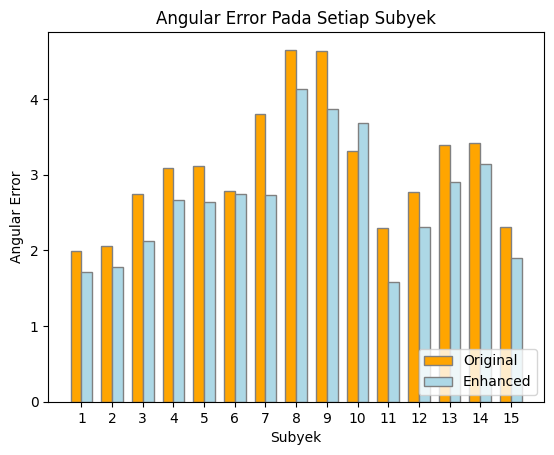

Original -> 3.090541124343872
Enhanced -> 2.6607863903045654


In [64]:
original_errors = []
enhanced_errors = []

for i in range(15):
  original_path = f"data_subset/original/p{i:02d}"
  enhanced_path = f"data_subset/enhanced/p{i:02d}"
  
  l_eye_images, r_eye_images, face_images, labels = read_data.load_subject_data(subject_dir=original_path, start=1000, end=1300)
  error = base_fare_net.validate(data=[l_eye_images, r_eye_images, face_images], labels=labels)
  original_errors.append(error)
  
  l_eye_images, r_eye_images, face_images, labels = read_data.load_subject_data(subject_dir=enhanced_path, start=1000, end=1300)
  error = enhanced_fare_net.validate(data=[l_eye_images, r_eye_images, face_images], labels=labels)
  enhanced_errors.append(error)

visualize_error_data(data1=original_errors, data2=enhanced_errors)

print(f"Original -> {tf.reduce_mean(original_errors)}" )
print(f"Enhanced -> {tf.reduce_mean(enhanced_errors)}")

### Testing Some Samples

In [43]:
def read_sample(subject, day, filename, dataset_type="original") :
  sample_path = f"data_subset/{dataset_type}/{subject}/{day}"
  
  l_eye_img = cv.imread(f"{sample_path}/left_eye/{filename}",cv.IMREAD_GRAYSCALE) / 255.0
  r_eye_img = cv.imread(f"{sample_path}/right_eye/{filename}",cv.IMREAD_GRAYSCALE) / 255.0
  face_img = cv.imread(f"{sample_path}/face/{filename}")
  face_img = cv.cvtColor(face_img,cv.COLOR_BGR2RGB)  / 255.0
  
  plt.subplot(1,3,1)
  plt.imshow(r_eye_img,cmap="gray")
  plt.subplot(1,3,2)
  plt.imshow(l_eye_img,cmap="gray")
  plt.subplot(1,3,3)
  plt.imshow(face_img)
  
  return np.array([l_eye_img]), np.array([r_eye_img]), np.array([face_img])

In [44]:
# Define Dark Sample
subject = "p03"
day = "day02"
filename = "0111.jpg"
label = list(map(float, "0.07106040965610984 0.050617094831419976 -0.996186894056699 0.08558168716315272 0.04973692693670491 -0.9950889472409996".split(" ")))

Validating...
Mean Angular Error => 2.913897752761841


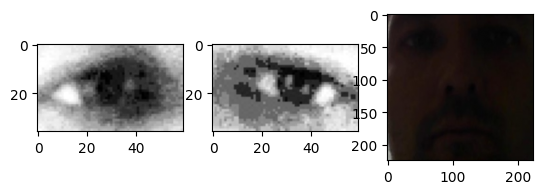

In [45]:
# Base Model Test
original_l, original_r, original_face = read_sample(subject=subject, day=day, filename=filename, dataset_type="original")
res = base_fare_net.validate(data=[original_l, original_r, original_face], labels=[label])

Validating...
Mean Angular Error => 2.3072383403778076


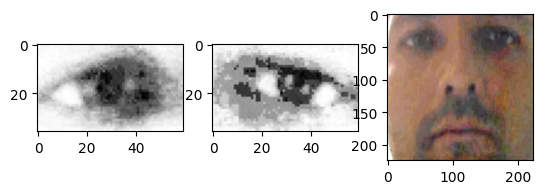

In [46]:
# Enhanced Model Test
enhanced_l, enhanced_r, enhanced_face = read_sample(subject=subject, day=day, filename=filename, dataset_type="enhanced")
res = enhanced_fare_net.validate(data=[enhanced_l, enhanced_r, enhanced_face], labels=[label])

In [48]:
# Define Light Sample
subject = "p03"
day = "day65"
filename = "0493.jpg"
label = list(map(float, "-0.1890216244156077 0.28034745221938584 -0.9411036773583366 -0.18468924007003062 0.29371003726887696 -0.9378828810730417".split(" ")))

Validating...
Mean Angular Error => 2.1612977981567383


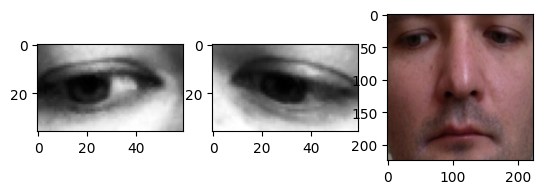

In [49]:
# Base Model Test
original_l, original_r, original_face = read_sample(subject=subject, day=day, filename=filename, dataset_type="original")
res = base_fare_net.validate(data=[original_l, original_r, original_face], labels=[label])

Validating...
Mean Angular Error => 1.5452237129211426


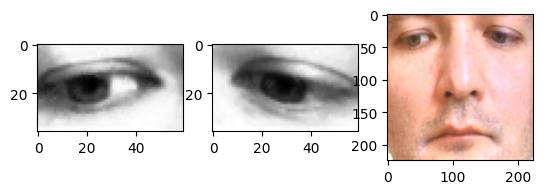

In [50]:
# Enhanced Model Test
enhanced_l, enhanced_r, enhanced_face = read_sample(subject=subject, day=day, filename=filename, dataset_type="enhanced")
res = enhanced_fare_net.validate(data=[enhanced_l, enhanced_r, enhanced_face], labels=[label])

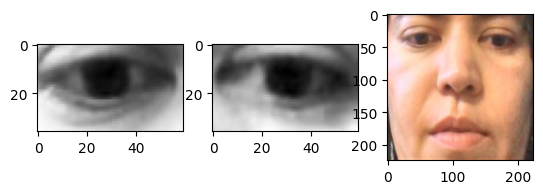

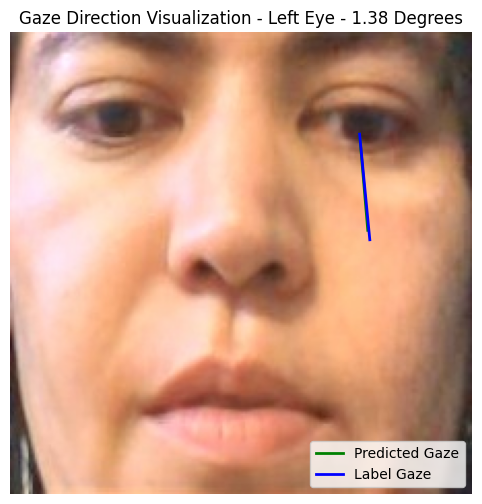

In [62]:
enhanced_fare_net.visualize_gaze(path="data_subset/enhanced/p00/day01/face/0005.jpg", label=[0.024747545916550293, 0.25614524540602923, -0.9663214642276107, 0.019550564064790076, 0.2554006796727642, -0.9666376095866737 ])

### Real Data Prediction Visualization

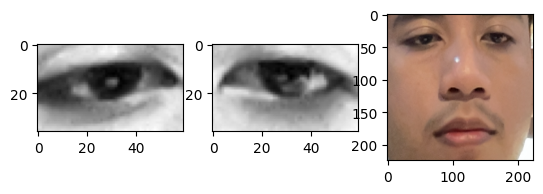

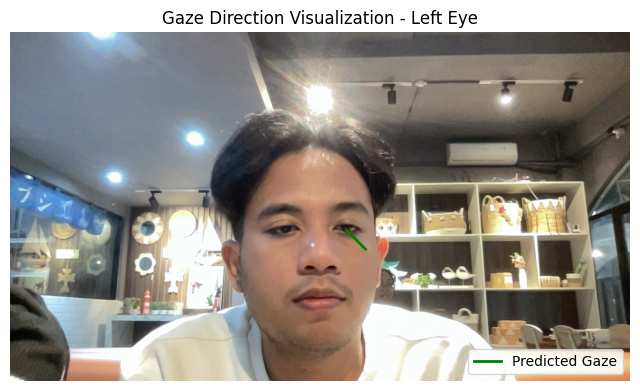

In [63]:
enhanced_fare_net.visualize_gaze(camera_index=1)